In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys, os
# from glob import glob
import imageio

In [2]:
# Note: normalize mean and std are standardized for ImageNet
transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
!git clone https://github.com/sam360digitmg/AI-Datasets.git

Cloning into 'AI-Datasets'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 3 (delta 0), pack-reused 29
Unpacking objects: 100% (33/33), done.


In [4]:
from zipfile import ZipFile
file_name = "/content/AI-Datasets/CNN/Animals.zip"


with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
train_dataset = datasets.ImageFolder(
    '/content/cats and dogs small/train',
    transform=transform
)
test_dataset = datasets.ImageFolder(
    '/content/cats and dogs small/test',
    transform=transform
)

In [6]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
)

In [7]:
vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [8]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
class VGGFeatures(nn.Module):
  def __init__(self, vgg):
    super(VGGFeatures, self).__init__()
    self.vgg = vgg
  
  def forward(self, X):
    out = self.vgg.features(X)
    out = self.vgg.avgpool(out)
    out = out.view(out.size(0), -1) # flatten
    return out

In [10]:
vggf = VGGFeatures(vgg)

In [11]:
out = vggf(torch.rand(1, 3, 224, 224))
out.shape

torch.Size([1, 25088])

In [12]:
Ntrain = len(train_dataset)
Ntest = len(test_dataset)
Ntrain, Ntest

(2002, 1000)

In [13]:
D = out.shape[1]
D

25088

In [14]:
X_train = np.zeros((Ntrain, D))
y_train = np.zeros((Ntrain, 1))
X_test = np.zeros((Ntest, D))
y_test = np.zeros((Ntest, 1))

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
vggf.to(device)

cuda:0


VGGFeatures(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [16]:
# get output
# populate X_train and Y_train
i = 0
with torch.no_grad():
  for inputs, targets in train_loader:
    # move data to GPU
    inputs = inputs.to(device)
    # get output
    output = vggf(inputs)

    # size of the batch (may not always be batch_size)
    sz = len(output)

    # assign to X_train and y_train
    X_train[i:i + sz] = output.cpu().detach().numpy()
    y_train[i:i + sz] = targets.view(-1, 1).numpy()

    # increment i
    i += sz
    print(i)

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2002


In [17]:
i = 0
with torch.no_grad():
  for inputs, targets in test_loader:
    # move data to GPU
    inputs = inputs.to(device)

    # get output
    output = vggf(inputs)

    # size of the batch (may not always be batch_size)
    sz = len(output)

    # assign to X_train and y_train
    X_test[i:i + sz] = output.cpu().detach().numpy()
    y_test[i:i + sz] = targets.view(-1, 1).numpy()

    # increment i
    i += sz
    print(i)

128
256
384
512
640
768
896
1000


In [18]:
X_train.max(), X_train.min()

(86.78292083740234, 0.0)

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train2 = scaler.fit_transform(X_train)
X_test2 = scaler.transform(X_test)

In [20]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
logr.fit(X_train2, y_train.flatten())
print("train score:", logr.score(X_train2, y_train.flatten()))
print("test score:", logr.score(X_test2, y_test.flatten()))

train score: 1.0
test score: 0.972


In [21]:
model = nn.Linear(D, 1)

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


Linear(in_features=25088, out_features=1, bias=True)

In [23]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [24]:
train_dataset2 = torch.utils.data.TensorDataset(
    torch.from_numpy(X_train2.astype(np.float32)),
    torch.from_numpy(y_train.astype(np.float32)),
)

test_dataset2 = torch.utils.data.TensorDataset(
    torch.from_numpy(X_test2.astype(np.float32)),
    torch.from_numpy(y_test.astype(np.float32)),
)

In [25]:
batch_size = 128
train_loader2 = torch.utils.data.DataLoader(dataset=train_dataset2, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader2 = torch.utils.data.DataLoader(dataset=test_dataset2, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [27]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [28]:
train_losses, test_losses = batch_gd(
    model,
    criterion,
    optimizer,
    train_loader2,
    test_loader2,
    epochs=10,
)

Epoch 1/10, Train Loss: 0.1482, Test Loss: 0.0851, Duration: 0:00:00.290324
Epoch 2/10, Train Loss: 0.0070, Test Loss: 0.0812, Duration: 0:00:00.168060
Epoch 3/10, Train Loss: 0.0016, Test Loss: 0.0864, Duration: 0:00:00.153895
Epoch 4/10, Train Loss: 0.0009, Test Loss: 0.0885, Duration: 0:00:00.153505
Epoch 5/10, Train Loss: 0.0007, Test Loss: 0.0894, Duration: 0:00:00.164205
Epoch 6/10, Train Loss: 0.0006, Test Loss: 0.0900, Duration: 0:00:00.165320
Epoch 7/10, Train Loss: 0.0005, Test Loss: 0.0905, Duration: 0:00:00.175164
Epoch 8/10, Train Loss: 0.0005, Test Loss: 0.0910, Duration: 0:00:00.166011
Epoch 9/10, Train Loss: 0.0004, Test Loss: 0.0914, Duration: 0:00:00.162782
Epoch 10/10, Train Loss: 0.0004, Test Loss: 0.0917, Duration: 0:00:00.151713


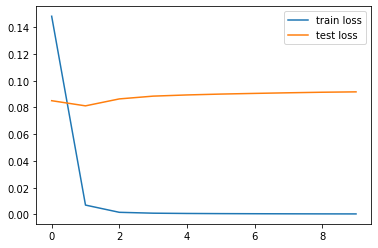

In [29]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [30]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_loader2:
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader2:
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 1.0000, Test acc: 0.9680


In [31]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [34]:
y_test = test_dataset2.targets

p_test = np.array([])
for inputs, targets in test_loader2:
  # move data to GPU
  inputs = inputs.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)
  
  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(2)))

AttributeError: ignored